In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os
import datetime
%matplotlib inline

In [66]:
# load the consolidated dataframe
df = pickle.load(open("../data/dataset_consolidated.p", "rb"))

In [18]:
# Load metadata (file genenerated in notebook exploratory_data_analysis)
meta = pickle.load(open("../data/metadata.p", "rb"))
meta_acceletarion = list(meta[meta.measure=='acceleration'].index)

In [19]:
# Subtypes of trial
df.trial_subtype.value_counts()

HB      115264
slip    115264
ITRS    115263
trip    115260
CS      103718
DS       76832
AS       76192
POG      57633
ITDS     57633
DSL      57631
NW       57631
SQ       57631
LCC      57631
RSS      57630
DSS      57630
ITCS     11526
Name: trial_subtype, dtype: int64

# Dimensionality Reduction

Remove columns with independent readings of X, Y and Z to use only those consolidated using the formula:

$\sqrt{x^2 + y^2 + z^2}$

In [67]:
df.head(2)

,Time,time_datetime,time_seconds,subject,trial_type,trial_num,trial_num_original,trial_subtype,r.ankle Acceleration X (m/s^2),r.ankle Acceleration Y (m/s^2),...,head resultant angular velocity,head resultant magnetic field,sternum resultant acceleration,sternum resultant angular velocity,sternum resultant magnetic field,waist resultant acceleration,waist resultant angular velocity,waist resultant magnetic field,FileName,target
0,1304799112429680,2011-05-07 20:11:52.429680,0.00000,1,ADLs,1,1,SQ,-9.691464,-0.240769,...,0.205785,83.535679,9.735780,0.265283,50.703732,9.864789,1.122888,57.649936,JXL_SQ_trial1.xlsx,0
1,1304799112437500,2011-05-07 20:11:52.437500,0.00782,1,ADLs,1,1,SQ,-9.698196,-0.245077,...,0.215989,83.284594,9.736724,0.272279,46.261673,9.845113,1.129150,53.942026,JXL_SQ_trial1.xlsx,0


In [68]:
# the columns whose metadata axis = XYZ are those with the consolidation of the values
cols_to_remove = list(meta[meta.axis != 'XYZ'].index) 
df.drop(cols_to_remove, axis=1, inplace=True)

# Marking rows with peak

For each consolidated measure (ex: 'waist resultant acceleration') another column is created to mark the peaks.

For each trial and for each one of the measures, the column will have value 1 for the peak and value 0 for the rest.

In [69]:
# columns to get the peak
columns_to_get_peak = list(meta[meta.axis=='XYZ'].index)
columns_to_get_peak

['r.ankle resultant acceleration',
 'r.ankle resultant angular velocity',
 'r.ankle resultant magnetic field',
 'l.ankle resultant acceleration',
 'l.ankle resultant angular velocity',
 'l.ankle resultant magnetic field',
 'r.thigh resultant acceleration',
 'r.thigh resultant angular velocity',
 'r.thigh resultant magnetic field',
 'l.thigh resultant acceleration',
 'l.thigh resultant angular velocity',
 'l.thigh resultant magnetic field',
 'head resultant acceleration',
 'head resultant angular velocity',
 'head resultant magnetic field',
 'sternum resultant acceleration',
 'sternum resultant angular velocity',
 'sternum resultant magnetic field',
 'waist resultant acceleration',
 'waist resultant angular velocity',
 'waist resultant magnetic field']

In [70]:
# create the columns (add suffix ' - peak') and set value 0 by default
for col in columns_to_get_peak:
    df[col+' - peak'] = 0

In [76]:
files = list(df.FileName.unique())
for file in files:
    df_file = df[df.FileName == file]
    
    for col in columns_to_get_peak:
        
        peak = df_file[col].idxmax()
        
        #store 1 in the row with the max value (the peak)
        df.iloc[peak, df.columns.get_loc(str(col+' - peak'))] = 1

### Example of graph highlighting the surrounding of the peak 

In [78]:
df_graph = df[(df.trial_num == 1) & (df.trial_subtype == 'AS') & (df.subject==1)]

In [85]:
peak_index = df_graph['waist resultant acceleration'].idxmax()
time_peak = df_graph.iloc[peak_index,df.columns.get_loc('time_seconds')]
interval = 4

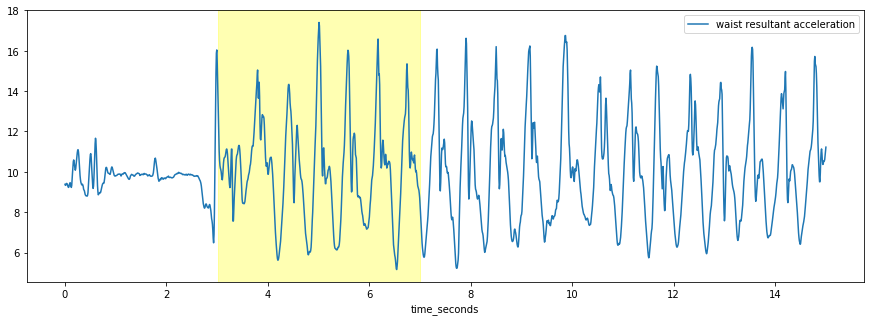

In [86]:
fig, ax = plt.subplots( figsize=(15,5))
df_graph.set_index('time_seconds')['waist resultant acceleration'].plot()
plt.axvspan(time_peak - interval/2.0, time_peak + interval/2.0, color='yellow', alpha=0.3)
ax.legend()